# 네이버 영화리뷰 감성분석

---

한국어로 된 네이버 영화 리뷰 텍스트를 이용하여 감성분석을 수행하고 이를 평가해본다.

## 데이터 준비와 확인
---

- 데이터 불러오기

In [16]:
train_data = pd.read_table(workspace_path + '/ratings_train.txt')
test_data  = pd.read_table(workspace_path + '/ratings_test.txt')
display(train_data.head(5))
display(train_data.tail(5))

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


## 데이터로더 구성
---

데이터로더 `data_loader`는 다음 기능을 수행해야 한다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전`word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [17]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [18]:
len(word_to_index.keys())

10000

In [19]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [20]:
get_decoded_sentence(X_train[1], index_to_word)

'. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나'

## 모델구성을 위한 데이터 분석 및 가공
---
- 데이터셋 내 문장 길이 분포

In [21]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455


- 적절한 최대 문장 길이 지정

In [22]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
# max_tokens = 100
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [23]:
X_train = add_padding(X_train, 'pre', maxlen)
X_test = add_padding(X_test, 'pre', maxlen)
X_train.shape, X_test.shape

((146182, 41), (49157, 41))

## 모델구성 및 validation set 구성
---

In [24]:
models = []
model_names = ['RNN', '1_D_CNN', '1_D_1_Layer_CNN']
vocab_size = len(word_to_index.keys())
word_vector_dim = 16

- RNN

In [25]:
models.append(get_rnn_model(vocab_size, word_vector_dim, 8))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


- 1-D Convolution Neural Network(1-D CNN)

In [26]:
models.append(get_one_d_cnn_model(vocab_size, word_vector_dim))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

- 1-D Convolution Neural Network(1-D CNN) with one layer

In [27]:
models.append(get_one_d_one_l_cnn_model(vocab_size, word_vector_dim))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련 개시
---

- validation set 분리

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=42)
print(X_train.shape)
print(y_train.shape)

(136182, 41)
(136182,)


- model 학습 시작

In [29]:
epochs=20

In [30]:
histories = [train(models[i], model_names[i], X_train, y_train, X_val, y_val, epochs) 
             for i in range(len(models))]

start train RNN ============================================== 
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 136182 samples, validate on 10000 samples
Epoch 1/20
136182/136182 - 8s - loss: 0.4936 - acc: 0.7766 - val_loss: 0.3615 - val_acc: 0.8498
Epoch 2/20
136182/136182 - 7s - loss: 0.3400 - acc: 0.8564 - val_loss: 0.3482 - val_acc: 0.8471
Epoch 3/20
136182/136182 - 7s - loss: 0.3173 - acc: 0.8670 - val_loss: 0.3403 - val_acc: 0.8552
Epoch 4/20
136182/136182 - 8s - loss: 0.3052 - acc: 0.8724 - val_loss: 0.3394 - val_acc: 0.8521
Epoch 5/20
136182/136182 - 7s - loss: 0.2941 - acc: 0.8768 - val_loss: 0.3379 - val_acc: 0.8515
Epoch 6/20
136182/136182 - 7s - loss: 0.2836 - acc: 0.8812 - val_loss: 0.3411 - val_acc: 0.8496
Epoch 7/20
136182/136182 - 7s - loss: 0.2746 - acc: 0.8848 - val_loss: 0.3428 - val_acc: 0.8506
Epoch 8/20
136182/136182 - 7s - loss: 0.2631 - acc: 0.8898 - val_loss: 0.3494 - val_acc: 0.8505
Epoch 9/20
136182/13618

- 테스트셋으로 평가

In [31]:
evaluation_res = [ models[i].evaluate(X_test,  y_test, verbose=2) for i in range(len(models)) ]
df = pd.DataFrame(evaluation_res, index=model_names, columns=['loss', 'accuracy'])
df

49157/49157 - 6s - loss: 0.3640 - acc: 0.8479
49157/49157 - 1s - loss: 0.3990 - acc: 0.8453
49157/49157 - 1s - loss: 0.3896 - acc: 0.8405


,loss,accuracy
RNN,0.363994,0.847875
1_D_CNN,0.398989,0.845251
1_D_1_Layer_CNN,0.389630,0.840491


테스트 결과 구상한 세가지 모델 중 RNN이 가장 성능이 좋았다.

## Loss, Accuracy 그래프 시각화
---

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


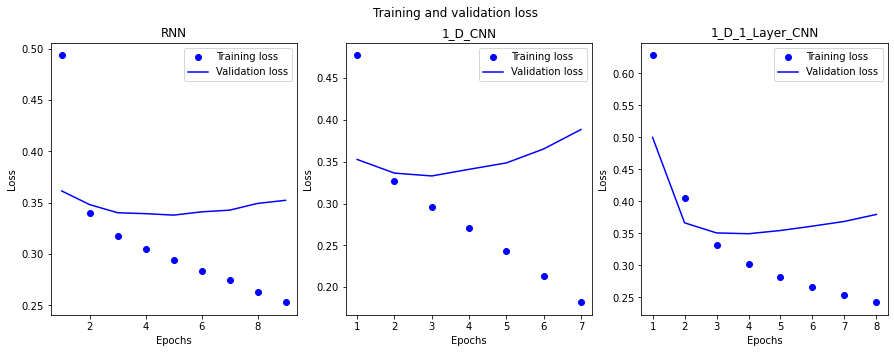

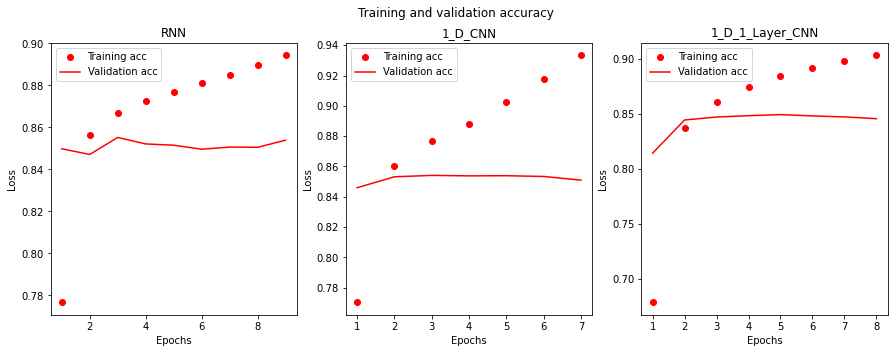

In [32]:
show_history_plot(histories, model_names)

## 학습된 Embedding 레이어 분석
---

- 학습한 Embedding 파라미터를 txt 파일로 저장

In [33]:
models[0].get_weights()[0]

array([[ 0.02435059, -0.07407113,  0.00871195, ..., -0.01922066,
         0.02684289, -0.01014234],
       [-0.02285335, -0.03341222, -0.02001619, ...,  0.01601448,
         0.03994607, -0.03269925],
       [-0.02863228,  0.01680109, -0.10421544, ..., -0.05001776,
         0.03328235,  0.04511382],
       ...,
       [-0.140026  , -0.15502006, -0.09372608, ...,  0.1623353 ,
         0.04926397,  0.15554827],
       [-0.2259723 , -0.27662897, -0.20075093, ...,  0.19210947,
        -0.05011493,  0.19194591],
       [-0.00666549, -0.05850453, -0.01976708, ..., -0.04978821,
        -0.01857595, -0.03466008]], dtype=float32)

In [35]:
save_embedding_layer(models, model_names)

In [ ]:
!ls ./word2vec

- 저장한 Embedding 파라미터를 읽어 word vector로 가져오기

In [37]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

base_path = workspace_path + '/data/suheeeee/'
word_vectors = [Word2VecKeyedVectors.load_word2vec_format(base_path + key + '.txt', binary=False)
                for key in model_names]

In [81]:
for i in range(len(word_vectors)): 
    print(model_names[i])
    test_word2vector(word_vectors[i])

RNN


,1,2,3,4,5,6,7,8,9
재미,너무,매우,심혜진,어이없이,거려서,다치,이렇게,완,넘
슬픔,ㅊ,공존,재발견,봣,메인,구입,틈,무서워서,안다
아깝,고대로,아까워,탐험,랍시고,모모,당첨,사이트,와요,멀미
명작,곁,명연기,개꿀,A,열린,조아,감탄,~~^^,완벽
별로,포기,어설퍼,실망,오만,어리석,아까웠,낮추,재미없,다라마
유치,대충,방어,난감,본다고,화내,구리,파탄,실망,기대치
답답,OOO,악몽,시시,포기,내려,치중,무한도전,제한,배달


1_D_CNN


,1,2,3,4,5,6,7,8,9
재미,여지껏,강동원,열라,도록,흥미,나옴,이정현,매우,그래서
슬픔,구입,김새론,탕웨이,낙원,깜찍,과자,어짜피,클로이,마음껏
아깝,재탕,개판,다이애나,끊,박정희,약했,발단,에서부터,써도
명작,로라,진진,싯,모건,드라마틱,쵝오,재밌,완벽,월요일
별로,다이,더냐,동거,방어,퇴화,당혹,어설프,횡설수설,밥맛
유치,재주,단조,나열,무미건조,빤,걸렸,망,나사,근거
답답,온갖,ㅓ,달려가,아휴,내려,강조,모니터,봐온,밥맛


1_D_1_Layer_CNN


,1,2,3,4,5,6,7,8,9
재미,네,애슐리,가물가물,바티칸,한국,약해서,녀,향해,췌
슬픔,시절,집중력,많,멋있,간다,best,동안,최고,블록버스터
아깝,접속,글,버림,불가,쩝,뽕짝,0,꺅,제멋대로
명작,보냅니다,역시,춘,심오,완벽,여러,g,밋기,홀딱
별로,--;,신파극,씨발,내리,더러움,차라리,날렸,밋밋,살인
유치,뭔,재미없,도망,칭찬,패러디,저러,제작비,...;;;,유치뽕
답답,겉멋,무식,미국식,권,무적,앉,명치,초등학생,영상물


## 한국어 Word2Vec 임베딩 활용하여 성능개선
---

#### 한국어 Word2Vec load
- 프로젝트를 위하여 세가지 word2vector를 사용하기로 하였다.
1. https://github.com/Kyubyong/wordvectors 에서 제공하는 Pre-trained model
2. https://github.com/Kyubyong/wordvectors 에서 제공하는 코드를 이용하여 생성한 wikipedia 데이터 기반의 word2vector
3. https://ratsgo.github.io/embedding/downloaddata.html 에서 제공하는 단어 수준의 임베딩

In [67]:
!ls ./data

Kyubyong  suheeeee  word-embeddings  wordvectors


In [90]:
from gensim.models import word2vec
paths = [ workspace_path + '/data/Kyubyong/ko.bin',
          workspace_path + '/data/wordvectors/data/ko.bin', 
          workspace_path + '/data/word-embeddings/word2vec' ]
wvs = [ word2vec.Word2Vec.load(path) for path in paths ]

In [91]:
for wv in wvs: print(wv.wv.vectors.shape)

(30185, 200)
(10007, 100)
(358043, 100)


#### word2vector 테스트

In [92]:
for wv in wvs: test_word2vector(wv.wv)

,1,2,3,4,5,6,7,8,9
재미,유머,매력,흥미,공짜,일자리,즐거움,비애,관객,향수
지루,편안,솔직,쓸쓸,차분,조용,냉정,자유분방,피곤,느긋
아깝,딱하,번거롭,아쉽,부끄럽,못마땅,편하,무난,애석,의아
명작,작품,대작,희극,희곡,거장,대표작,단편집,히트곡,가곡
별로,지역별,전혀,각기,개별,따로,마다,별,딱히,다소
유치,추진,확충,입주,선진화,육성,모금,신공항,확보,홍보
답답,무뚝뚝,난감,지저분,난잡,불쾌,비통,안타깝,멍청,간절


,1,2,3,4,5,6,7,8,9
재미,흥미,외모,매력,관객,면모,목소리,인기,분위기,재주
별로,별,지역별,따로,개별,전혀,각,마다,그다지,문항
유치,추진,확보,모금,마련,확충,조달,개설,육성,충당


,1,2,3,4,5,6,7,8,9
재미,재미있,스릴감,재밌,스토리,~~~~~~~~,^^*,정말,무지무지,스릴
지루,흥미진진,졸립,찝찝,따분,..;;,산만,식상,갑갑,뻔해서
아깝,아까운,아까워,아까울,아까웠,진짜,..,반개,...,안타까워서
명작,걸작,졸작,.!!,정말,....,...,..,작품,~~~~~~~
별로,딱히,솔직히,별루,별론데,꽤,~~~~~~~~,그냥저냥,괜찬고,그래도
유치,기대,오글거리,.;;;,던데요,암튼,갑갑,정말,..;;,봣습니다
답답,갑갑,찝찝,산만,눈쌀,흐뭇,졸립,피곤,찜찜,깝깝


In [ ]:
첫번째 것이 가장 성능이 좋고 그 다음음 마지막 것

#### 모델의 임베딩 레이어를 Word2Vec의 것으로 교체

- embedding matrix 생성

In [106]:
vocab_size = len(word_to_index.keys()) 
embedding_matrixs = [ get_embedding_matrix(vocab_size, 
                                           wv.wv.vectors.shape[1], 
                                           index_to_word, wv) for wv in wvs ]

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


#### embedding matrix를 적용한 모델 생성

In [109]:
word_vector_dims = [ wv.wv.vectors.shape[1] for wv in wvs ]
model_group = [ [ get_rnn_model(vocab_size, word_vector_dims[i], 8, embedding_matrixs[i]),
             get_one_d_cnn_model(vocab_size, word_vector_dims[i], embedding_matrixs[i]), 
             get_one_d_one_l_cnn_model(vocab_size, word_vector_dims[i], embedding_matrixs[i])] 
            for i in range(3) ]

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 41, 200)           2000000   
____________________

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 41, 100)           1000000   
____________________

In [111]:
model_group

[[<tensorflow.python.keras.engine.sequential.Sequential at 0x7f83a8c65090>,

#### 모델 학습

In [110]:
histories = []
for models in model_group:
    for i in range(len(models)):
        histories.append(train(models[i], model_names[i], X_train, y_train, X_val, y_val, epochs))

start train RNN ============================================== 
Train on 136182 samples, validate on 10000 samples
Epoch 1/20
136182/136182 - 17s - loss: 0.5060 - acc: 0.7475 - val_loss: 0.3920 - val_acc: 0.8288
Epoch 2/20
136182/136182 - 17s - loss: 0.3572 - acc: 0.8457 - val_loss: 0.3569 - val_acc: 0.8443
Epoch 3/20
136182/136182 - 17s - loss: 0.3184 - acc: 0.8656 - val_loss: 0.3472 - val_acc: 0.8478
Epoch 4/20
136182/136182 - 17s - loss: 0.2967 - acc: 0.8766 - val_loss: 0.3444 - val_acc: 0.8523
Epoch 5/20
136182/136182 - 16s - loss: 0.2808 - acc: 0.8841 - val_loss: 0.3472 - val_acc: 0.8516
Epoch 6/20
136182/136182 - 17s - loss: 0.2676 - acc: 0.8907 - val_loss: 0.3609 - val_acc: 0.8491
Epoch 7/20
136182/136182 - 17s - loss: 0.2550 - acc: 0.8973 - val_loss: 0.3518 - val_acc: 0.8538
Epoch 8/20
136182/136182 - 16s - loss: 0.2431 - acc: 0.9024 - val_loss: 0.3585 - val_acc: 0.8524
Epoch 00008: early stopping
train completed ============================================== 
start train 1_D_C

Epoch 1/20
136182/136182 - 11s - loss: 0.4676 - acc: 0.7735 - val_loss: 0.3659 - val_acc: 0.8452
Epoch 2/20
136182/136182 - 10s - loss: 0.3422 - acc: 0.8563 - val_loss: 0.3440 - val_acc: 0.8544
Epoch 3/20
136182/136182 - 10s - loss: 0.3133 - acc: 0.8705 - val_loss: 0.3451 - val_acc: 0.8543
Epoch 4/20
136182/136182 - 11s - loss: 0.2963 - acc: 0.8787 - val_loss: 0.3451 - val_acc: 0.8559
Epoch 5/20
136182/136182 - 12s - loss: 0.2838 - acc: 0.8842 - val_loss: 0.3403 - val_acc: 0.8559
Epoch 6/20
136182/136182 - 10s - loss: 0.2722 - acc: 0.8906 - val_loss: 0.3414 - val_acc: 0.8558
Epoch 7/20
136182/136182 - 10s - loss: 0.2616 - acc: 0.8952 - val_loss: 0.3483 - val_acc: 0.8535
Epoch 8/20
136182/136182 - 10s - loss: 0.2516 - acc: 0.9003 - val_loss: 0.3511 - val_acc: 0.8551
Epoch 9/20
136182/136182 - 10s - loss: 0.2422 - acc: 0.9052 - val_loss: 0.3550 - val_acc: 0.8528
Epoch 00009: early stopping
train completed ============================================== 
start train 1_D_CNN ===============

#### 평가

In [119]:
for model_idx in range(len(model_group)):
    print('word2vec number :: {}'.format(model_idx))
    evaluation_res = [ model_group[model_idx][i].evaluate(X_test,  y_test, verbose=2)
                       for i in range(len(model_group[model_idx])) ]

word2vec number :: 0
49157/49157 - 7s - loss: 0.3677 - acc: 0.8501
49157/49157 - 2s - loss: 0.4015 - acc: 0.8426
49157/49157 - 1s - loss: 0.4099 - acc: 0.8279
word2vec number :: 1
49157/49157 - 7s - loss: 0.3693 - acc: 0.8480
49157/49157 - 1s - loss: 0.3865 - acc: 0.8404
49157/49157 - 1s - loss: 0.4011 - acc: 0.8256
word2vec number :: 2
49157/49157 - 6s - loss: 0.3640 - acc: 0.8479
49157/49157 - 1s - loss: 0.4134 - acc: 0.8455
49157/49157 - 1s - loss: 0.3715 - acc: 0.8458


#### 추가실험
- 결과가 가장 좋은 첫번째 word2vec와 rnn 모델을 이용하여 더 좋은 결과를 얻기 위해 하이퍼 파리미터를 조정해 보고자 한다.

In [129]:
word_vector_dims = wvs[0].wv.vectors.shape[1]
vocab_size = len(word_to_index.keys()) 

rnn_models = [ get_rnn_model(vocab_size, word_vector_dims, 16, embedding_matrixs[0]),
               get_rnn_model(vocab_size, word_vector_dims, 32, embedding_matrixs[0]),
               get_rnn_model(vocab_size, word_vector_dims, 64, embedding_matrixs[0]),
               get_rnn_model(vocab_size, word_vector_dims, 128, embedding_matrixs[0]),
               get_rnn_model(vocab_size, word_vector_dims, 256, embedding_matrixs[0])]

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 16)                13888     
_________________________________________________________________
dense_52 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 17        
Total params: 2,014,177
Trainable params: 2,014,177
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 41, 200)           2000000   
____________________

In [130]:
rnn_models_history = [train(model, model_names[0], X_train, y_train, X_val, y_val, 20)
                      for model in rnn_models ]

start train RNN ============================================== 
Train on 136182 samples, validate on 10000 samples
Epoch 1/20
136182/136182 - 19s - loss: 0.4977 - acc: 0.7506 - val_loss: 0.3878 - val_acc: 0.8277
Epoch 2/20
136182/136182 - 17s - loss: 0.3495 - acc: 0.8489 - val_loss: 0.3457 - val_acc: 0.8529
Epoch 3/20
136182/136182 - 17s - loss: 0.3092 - acc: 0.8697 - val_loss: 0.3383 - val_acc: 0.8545
Epoch 4/20
136182/136182 - 17s - loss: 0.2855 - acc: 0.8812 - val_loss: 0.3360 - val_acc: 0.8588
Epoch 5/20
136182/136182 - 18s - loss: 0.2681 - acc: 0.8904 - val_loss: 0.3409 - val_acc: 0.8556
Epoch 6/20
136182/136182 - 20s - loss: 0.2521 - acc: 0.8972 - val_loss: 0.3475 - val_acc: 0.8539
Epoch 7/20
136182/136182 - 19s - loss: 0.2380 - acc: 0.9043 - val_loss: 0.3557 - val_acc: 0.8551
Epoch 8/20
136182/136182 - 19s - loss: 0.2227 - acc: 0.9113 - val_loss: 0.3628 - val_acc: 0.8595
Epoch 00008: early stopping
train completed ============================================== 
start train RNN =

In [132]:
rnn_models[0].evaluate(X_test,  y_test, verbose=2)

49157/49157 - 6s - loss: 0.3705 - acc: 0.8526


[0.3704558219982323, 0.8525744]

In [134]:
evaluation_res = [ rnn_models[i].evaluate(X_test,  y_test, verbose=2) for i in range(len(rnn_models)) ]
df = pd.DataFrame(evaluation_res, index=[16,32,64,128,256], columns=['loss', 'accuracy'])

49157/49157 - 6s - loss: 0.3705 - acc: 0.8526
49157/49157 - 7s - loss: 0.3661 - acc: 0.8555
49157/49157 - 7s - loss: 0.3715 - acc: 0.8567
49157/49157 - 11s - loss: 0.3848 - acc: 0.8611
49157/49157 - 28s - loss: 0.5107 - acc: 0.8587


In [135]:
df

,loss,accuracy
16,0.370456,0.852574
32,0.366094,0.855483
64,0.371462,0.856704
128,0.384762,0.861139
256,0.510656,0.858738


## 결론
---

### 요약
- 목표 : 네이버 영화리뷰 데이터셋을 이용하여 감성분류기를 만들어 본다.
- 프로젝트 진행 과정
    - 데이터 전처리
        - 네이버 영화 리뷰 데이터셋을 다운로드 받아 불러들인다. [link](https://github.com/e9t/nsmc)
        - 데이터 로더를 구성하여 데이터 중복제거, Mecab 토크나이저를 이용한 토큰화 등의 과정을 걸쳐 데이터를 컴퓨터가 이해할 수 있도록 수치화 시킨다.
        - 문장의 길이를 적절가게 조정하여 모든 문장이 같은 길이를 가지도록 변환한다.
    - 모델 설계/훈련/평가 : RNN, 1-D Convolution Neural Network, Global max pooling Layer 하나만을 사용하는 모델 -> 총 3개의 모델을 사용하여 훈련을 시키고 accuracy와 loss를 구한다. 이때, accuracy와 loss를 그래로 나타내어 추이를 확인한다.
    - embedding layer 분석
         - 위의 모델에서 학습된 embedding 파라미터를 txt 파일로 저장후 gesim을 이용하여 다시 읽어들여 word vector로 사용한다.
         - 단어 10개를 선정하여 word vector의 성능을 평가한다.
    - 기존에 학습된 Word Embedding 모델을 읽어들여 위 모델의 성능을 향상 시켜본다.

### 프로젝트 평가
1. 다양한 방법(3가지 이상의 모델)으로 Text Classification 태스크를 성공적으로 구현하였는가?
- 3가지 모델을 수립하여 프로젝트를 진행하였고, 적절한 결과를 얻어내는 것에 성공하였다.

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였는가? gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석하였는가?
- 영화 평가에 자주 등장하는 7가지 단어(재미, 지루, 아깝, 명작, 별로, 유치, 답답)를 선정하여 자체학습한 임베딩과 사전학습 임베딩에서 위 단어와 가장 유사항 단어를 각 단어별로 10개씩 뽑내 내역을 확인하였다.
- 프로젝트에서 총 3가지 사전학습 임베딩을 사용하였는데 유사단어 찾기에서 직관적으로 가장 좋은 성능을 보인 것은 세번째 임베딩이었다. 하지만, 이를 학습시킨 후 모델 성능 평가에서는 첫번째 임베딩이 가장 좋은 성능을 보여주었다.

3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성하였는가? 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성하였는가?
-  같은 하이퍼 파마리터를 사용할였을 때, 다음과 같이 accuracy가 변화하였다.
    | 모델 | 자제학습 | embedding1 | embedding2 | embedding3 |
    |:----:|:--------:|:----------:|:----------:|:----------:|
    | RNN  | 0.847875 | 0.8501     | 0.8480     | 0.8479     |
    | 1-D CNN | 0.845251 | 0.8426  | 0.8404     | 0.8455     |
    | GlobalMaxPooling1D | 0.840491 | 0.8279 | 0.8256 | 0.8458 |
- 추가적으로 가장 성능이 좋았던 RNN-embedding1 조합을 이용하여 모델의 하이퍼마라메터 값이 units 값을 변경 시키며 실험을 진행하였을 때, 다음과 같이 accuracy가 변화하였다.
    | units    | loss	    | accuracy |
    |:--------:|:----------:|:--------:|
    | 16	   | 0.370456	| 0.852574 |
    | 32	   | 0.366094	| 0.855483 |
    | 64	   | 0.371462	| 0.856704 |
    | 128	   | 0.384762	| 0.861139 |
    | 256	   | 0.510656	| 0.858738 |
- 프로젝트를 통하어 얻을 수 있었던 가장 높은 accuracy는 86%로 85% 이상을 달성하였다.

### 회고
1. 이번 프로젝트에서 어려웠던 점
    - 프로젝트를 진행하는 것에 있어서 자연어 처리를 처음 진행해 본다!-는 점 자체가 어려웠다. 자연어는 이전에 주로 다루었던 텍스트 데이터와 이미지 데이터와 다르게 인코딩을 거치고 나면 원본을 어떤 느낌이었는지 전혀 알아볼 수 없기 때문에 중간과정을 print하여 보아도 이게 잘 처리 되고 있는 것인지 판단하기가 어려워 진행에 난항을 겪었다. 다행히도 shape를 자주 찍어보면 이 점을 조금이나마 극복할 수 있다는 것을 중간에 깨달아 프로젝트 후반에는 데이터의 형태에 어영부영 적응할 수 있었다.
    - 가장 큰 고비는 accuracy가 85% 이상을 가지 못하여 해매이던 때였다. 루브릭 평가의 기준으로부터 미루어봤을 때, 기존에 학습 된 임베딩을 모델로 들고왔을 경우, accuracy의 극적으로 변화할 것만 같았는데 실상은 전혀 그렇지 못하였다. 그런 이유로 임베딩을 추가로 2개 더 가져와 테스트를 진행하였지만 결과를 비슷하였다. 최종적으로 85%를 넘어 86%에 도달한 것은 하이퍼 파라미터를 보정하여 모델을 변화시켜 주었을 때였다. 모델을 성능을 올리려면 하나의 요소에 집착할 것이 아니라 전체적으로 살피고 변화를 주어야 한다는 점을 깨닫게 된 순간이었다.
2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    - 기존의 classification과 다르게 이번 프로젝트의 predict 값은 0 또는 1로 딱 나오는 것이 아니라 0과 1 사이의 실수값으로 도출된다! 85%의 늪에서 허우적거리고 있던 시절, accuary 말고 다른 평가 지표들도 확인해 보고 싶어서 predict를 실행해 보고 알게 된 사항이다. 추가로 train 과정에서 accuracy와 loss 뿐만 아니라 precision과 recall 값도 history로 얻을 수 있다는 점도 알게 되었다. 다만, 해당 수치들을 어떻게 연산하는지에 대한 의문이 아직 남아 있다. prediect의 결과가 딱 기존에 입력하는 target 값과 다른데, 그럼 이 값을 반올림을 하거나 하는 과정을 거치는 것인지 아직 찾아보지 못하였다.
3. 자기 다짐
    - 이번 프로젝트 aiffel 인생에 있어서 큰 다짐을 하게 되었다. going deeper 단계에서 절대 자연어 처리 과정으로 가지 않을 것이다.....절대.......... .... .. ..  ..  .     .

## Code Cellection
---

#### import packages

In [1]:
import os
import pandas as pd
import numpy as np
import urllib.request
import re

from konlpy.tag import Okt
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline


workspace_path = os.getenv('HOME')+'/workspace/aiffel-exploation-workspace/E04_sentiment_classification'

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aiffel-dj1/anaconda3/envs/ai

#### 데이터 로더 : `load_data`

In [2]:
def load_data(train_data, test_data, num_words=10000):
    tokenizer = Mecab()
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

#### `get_encoded_sentence`

In [3]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

#### `get_encoded_sentences`

In [4]:
# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

#### `get_decoded_sentence`

In [5]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

#### `get_decoded_sentences`

In [6]:
# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### `add_padding`

In [7]:
def add_padding(data, padding, maxlen):
    return keras.preprocessing.sequence.pad_sequences(data,
                                                      value=word_to_index["<PAD>"],
                                                      padding=padding, 
                                                      maxlen=maxlen)

#### `get_rnn_model`

In [8]:
def get_rnn_model(vocab_size, word_vector_dim, units, embedding_matrix=""):
    rnn_model = keras.Sequential()
    if embedding_matrix == "":
        rnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    else:
        rnn_model.add(keras.layers.Embedding(vocab_size, 
                                             word_vector_dim, 
                                             embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                             input_length=maxlen, 
                                             trainable=True))   # trainable을 True로 주면 Fine-tuning
    rnn_model.add(keras.layers.LSTM(units))
    rnn_model.add(keras.layers.Dense(units, activation='relu'))
    rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

    rnn_model.summary()
    return rnn_model

#### `get_one_d_cnn_model`

In [9]:
def get_one_d_cnn_model(vocab_size, word_vector_dim, embedding_matrix=""):
    one_d_cnn_model = keras.Sequential()
    
    if embedding_matrix == "":
        one_d_cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    else:
        one_d_cnn_model.add(keras.layers.Embedding(vocab_size, 
                                                   word_vector_dim, 
                                                   embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                                   input_length=maxlen, 
                                                   trainable=True))   # trainable을 True로 주면 Fine-tuning
    one_d_cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    one_d_cnn_model.add(keras.layers.MaxPooling1D(5))
    one_d_cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    one_d_cnn_model.add(keras.layers.GlobalMaxPooling1D())
    one_d_cnn_model.add(keras.layers.Dense(8, activation='relu'))
    one_d_cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    one_d_cnn_model.summary()
    return one_d_cnn_model

#### `get_one_d_one_l_cnn_model`

In [10]:
def get_one_d_one_l_cnn_model(vocab_size, word_vector_dim, embedding_matrix=""):
    one_d_one_l_cnn_model = keras.Sequential()
    if embedding_matrix == "":
        one_d_one_l_cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    else:
        one_d_one_l_cnn_model.add(keras.layers.Embedding(vocab_size, 
                                                   word_vector_dim, 
                                                   embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                                   input_length=maxlen, 
                                                   trainable=True))   # trainable을 True로 주면 Fine-tuning
    one_d_one_l_cnn_model.add(keras.layers.GlobalMaxPooling1D())
    one_d_one_l_cnn_model.add(keras.layers.Dense(8, activation='relu'))
    one_d_one_l_cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    one_d_one_l_cnn_model.summary()    
    return one_d_one_l_cnn_model

#### `train`

In [125]:
def train(model, model_name, X_train, y_train, X_val, y_val, epochs):
    # val_loss이 증가하면, 과적합 징후므로 val_loss이 4회 증가하면 학습을 조기 종료(Early Stopping)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    print("start train {} ============================================== ".format(model_name))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
              
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        callbacks=[es],
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=2)
    print("train completed ============================================== ".format(model_name))
    return history.history

#### `get_history_plot`

In [12]:
def get_sub_plot(history, targets, labels, fig, n, title, color):
    x = range(1, len(history[targets[0]]) +1 )
    plt = fig.add_subplot(1, 3, n)
    plt.plot(x, history[targets[0]], color + 'o', label=labels[0])
    plt.plot(x, history[targets[1]], color,  label=labels[1])
    plt.set_xlabel('Epochs')
    plt.set_ylabel('Loss')
    plt.set_title(title)
    plt.legend()

In [13]:
def show_history_plot(histories, model_names):
    targets = [['loss', 'val_loss'], ['acc', 'val_acc']]
    labels = [['Training loss', 'Validation loss'], ['Training acc', 'Validation acc']]
    titles = ['Training and validation loss','Training and validation accuracy']
    colors = ['b', 'r']
    
    for i in range(2):
        fig = plt.figure(figsize=(15, 5))
        for j in range(len(histories)):
            get_sub_plot(histories[j], targets[i], labels[i], fig, j+1, model_names[j], colors[i])
        fig.suptitle(titles[i])
        fig.show()

#### `save_embedding_layer`

In [14]:
def save_embedding_layer(models, model_names):
    for i in range(len(models)):
        
        path = workspace_path + '/data/suheeeee/' + model_names[i] + '.txt'
        vectors = models[i].get_weights()[0]
        
        f = open(path, 'w')
        f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다

        # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
        for i in range(4,vocab_size):
            f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))
        f.close()

#### `test_word2vector`

In [84]:
def test_word2vector(wv):
    words = ["재미", "지루", "아깝", "명작", "별로", "유치", "답답"]

    df = pd.DataFrame(columns=range(1,10))

    for word in words:
        if word in wv.vocab:
            new_row = pd.DataFrame([pd.Series([res[0] for res in  wv.most_similar(word)])],
                                    columns=df.columns, index=[word])
            df = df.append(new_row)
    
    display(df)

#### `get_embedding_matrix`

In [105]:
def get_embedding_matrix(vocab_size, word_vector_dim, index_to_word, wv):
    embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

    # embedding_matrix에 Word2Vpartial_y_trainec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
    for i in range(4,vocab_size):
        if index_to_word[i] in wv:
            embedding_matrix[i] = wv[index_to_word[i]]
            
    return embedding_matrix

## ref
- [딥러닝을 이용한 자연어 처리 입문-영어/한국어 Word2Vec 실습](https://wikidocs.net/50739)
- [딥 러닝을 이용한 자연어 처리 입문-RNN을 이용한 텍스트 분류](https://wikidocs.net/44249)